In [1]:
%load_ext autoreload
%autoreload 2
from model import *
from neurons import *
from synaptics import *
from utils import *
from protocols import *
from shallow_models import *
from vis_functions import *
from tools import *
from pyvis.network import Network
from delayed_paper import *
res = .1
plt.style.use(['dark_background'])


{0: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 1: [9, 3, 1, 7, 8, 10, 4, 2, 5, 6], 2: [2, 8, 7, 3, 9, 1, 4, 5, 6, 10], 3: [2, 6, 5, 9, 1, 8, 7, 4, 3, 10], 4: [9, 3, 6, 8, 4, 2, 10, 1, 5, 7], 5: [1, 6, 3, 7, 4, 8, 5, 2, 9, 10], 6: [5, 9, 2, 4, 1, 6, 3, 10, 8, 7], 7: [3, 1, 5, 10, 9, 7, 8, 6, 2, 4], 8: [5, 3, 8, 1, 7, 4, 6, 9, 10, 2], 9: [6, 3, 8, 4, 1, 9, 10, 7, 2, 5], 10: [2, 6, 3, 5, 4, 8, 10, 7, 9, 1]}


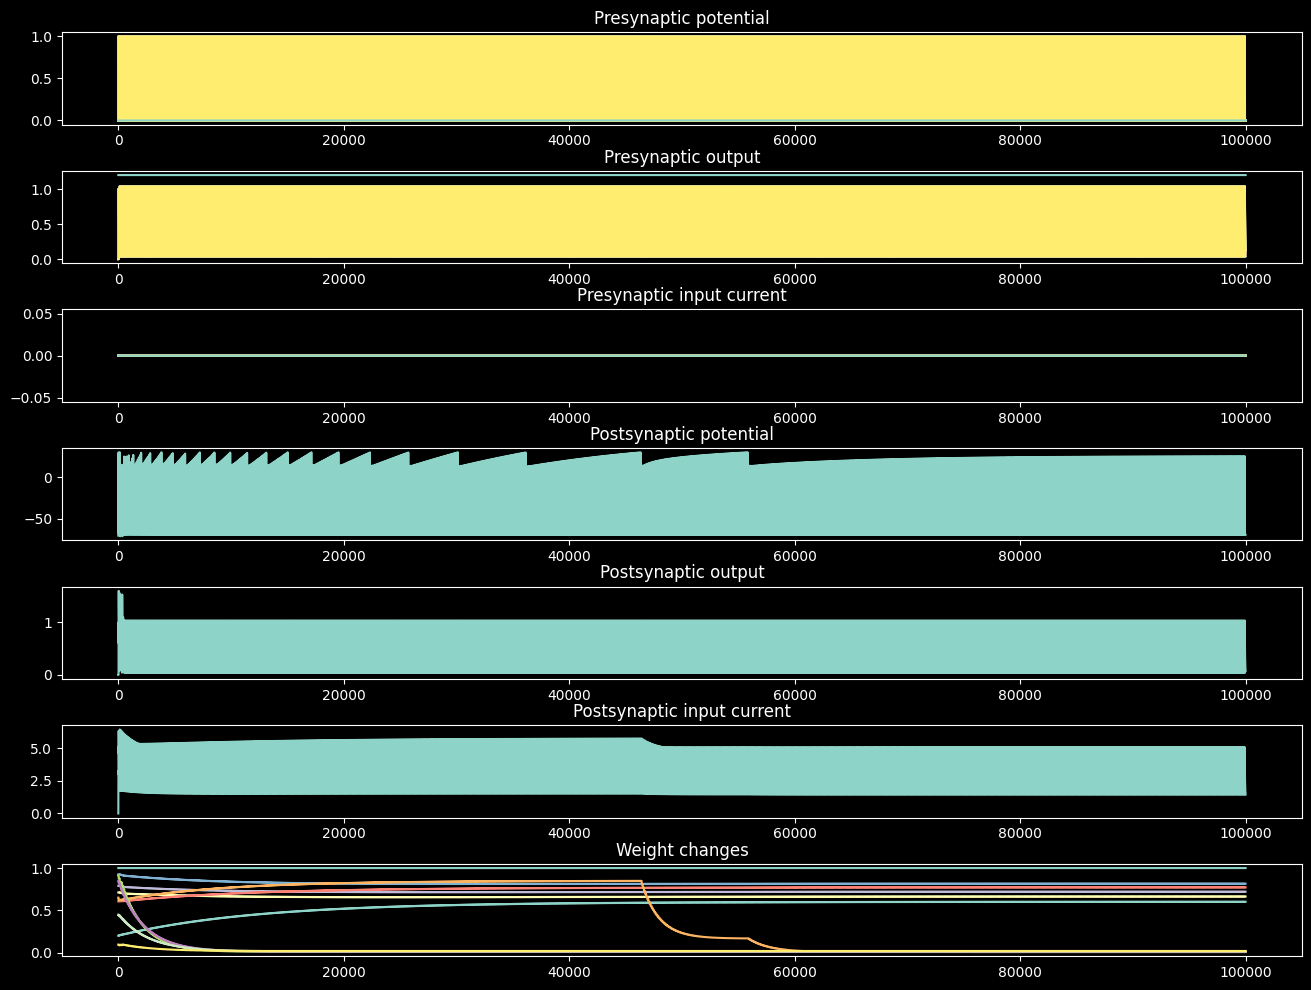

In [2]:
model = one_neu_dynamics(num_input=10, scale=1.9, interval=4, learning_rule='pair-stdp', delayed=False,
                         lr=.01, tau=10, d_lr=.1, synaptic_limit=False, slow_variable_limit=False, max_delay=100,
                         b=7.6, slow_tau=100, forget_tau=100, delay=1, noise=0, weights=(.4, .6), stick_del_w_to_one=True)

patterns, num_inputs, num_patterns = sampler(num_inputs=10, num_rand_patterns=10)
print(patterns)

dc_source = DirectNeuron(I=1.2)
dc_conductor = NeverLearn(dc_source, model.neurons[0])
model.add_neuron(dc_source)
model.add_synapse(dc_conductor)
model.reload_graph()


# TRAIN
model.set_scale(1.32)
model.set_noise(0)
model.set_random_weights(ranges=(0, 1))
model, *_ = run_protocol(model, sampler=patterns, sample_time=100, interval=4,
                    runs=1000, lr=.01, d_lr=1, test=False,
                    freeze_delays=True, gather_data=True, plot=True, plast_type='pair_stdp',
                    return_gatherer=False, gather_delays=False, logger=None, init_weights=None,
                    stick_del_w_to_one=True)

    

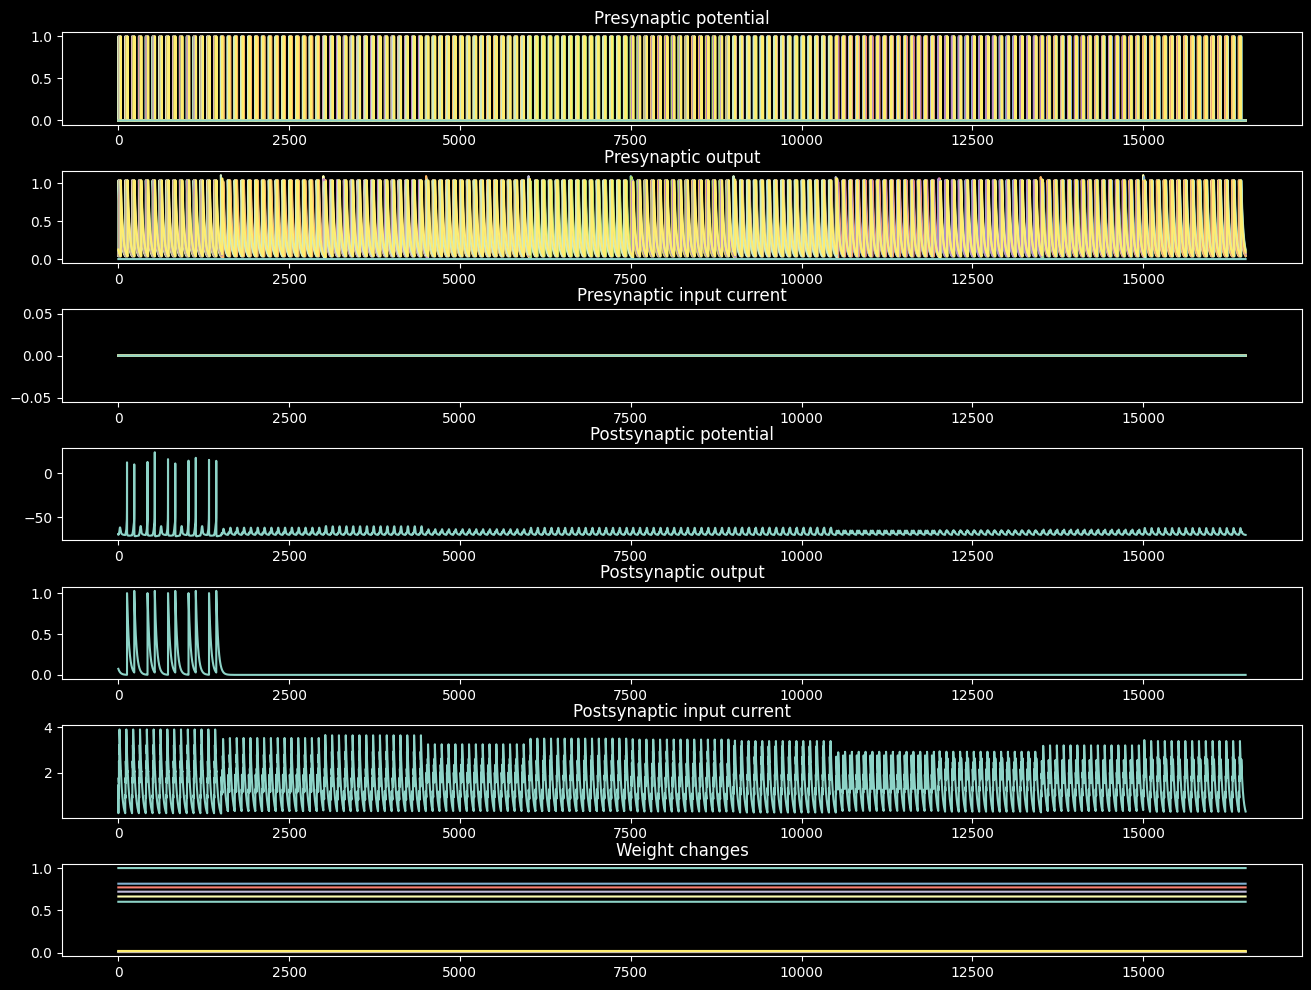

In [3]:
# TEST
model.neurons[11].set_impulse(0)
model.set_scale(1.32)
model.set_noise(0)
num_test_runs = 15

model, delay, dd, num_spikes, gatherer = run_protocol(model, sampler=patterns, sample_time=100, interval=4,
                    runs=num_test_runs, lr=0, d_lr=0, test=True,
                    freeze_delays=True, gather_data=True, plot=True, plast_type=None,
                    return_gatherer=True, gather_delays=False, logger=None, init_weights=None,
                    stick_del_w_to_one=True)

In [4]:
freqs = num_spikes / num_test_runs
freq_known = freqs[0]
freq_unknown = np.sum(freqs[1:]) / len(freqs[1:])
Q = np.divide(2*freq_known, (freq_known + freq_unknown)) - 1
print(f'Q = {Q}')
print(f'Accuracy = {(freq_known / (freq_known + freq_unknown)) * 100} %')

Q = 1.0
Accuracy = 100.0 %


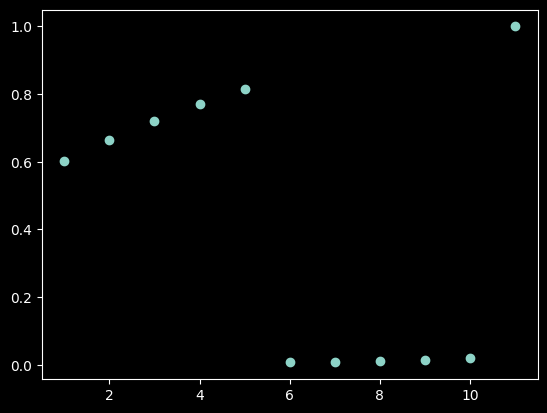

In [5]:
weights = []
for i in model.syn_by_edge.keys():
    weights.append(model.get_weight(i))
plt.scatter(list(range(1, 12)), weights)

# kinda convs

In [6]:
from rustyspikes import *

In [7]:
log = LogHandler(path=r'C:\Users\iamkg0\Desktop\projects\rustyspikes\Prototype\logs\testing', filename='rfs.csv')
log.create()

===== WARNING! =====
C:\Users\iamkg0\Desktop\projects\rustyspikes\Prototype\logs\testing\rfs.csv already exists!
Data hasnt been overwritten yet!
NOTICE:
.define_cols() method will remove all previous data
.write_sample() method will append new data


In [8]:
log.define_cols(('input_size', 'aw_time', 'sample_time', 'lr', 'runs', 'd_lr', 'scale', 'rt',
                            'num_patterns', 'synaptic_limit', 'slow_var_limit', 'slow_tau', 'forget_tau',
                            'spikes', 'b', 'max_delay', 'learning_rule'))
log.map


===== WARNING! =====
If there was any data, now theres none
Columns were configured
C:\Users\iamkg0\Desktop\projects\rustyspikes\Prototype\logs\testing\rfs.csv


{'input_size': [],
 'aw_time': [],
 'sample_time': [],
 'lr': [],
 'runs': [],
 'd_lr': [],
 'scale': [],
 'rt': [],
 'num_patterns': [],
 'synaptic_limit': [],
 'slow_var_limit': [],
 'slow_tau': [],
 'forget_tau': [],
 'spikes': [],
 'b': [],
 'max_delay': [],
 'learning_rule': []}

In [9]:
def train_protocol(model, gatherer, time=100000, rule='pair_stdp', lr=0.1):
    model.set_rule_to_all(rule)
    model.set_lr_to_all(lr)
    model.set_slow_var_limit(limit=1)
    t = np.arange(int(time / res)) * res
    for i in t:
        model.tick()
        gatherer.gather_stats()
    return model, gatherer

def test_run(model, gatherer, time=500):
    model.set_rule_to_all(None)
    t = np.arange(int(time / res)) * res
    for i in t:
        model.tick()
        gatherer.gather_stats()
    return model, gatherer

def reverse_order(model, ids, aw=5):
    for i in range(1, len(ids)+1):
        model.neurons[ids[-i]].awaiting_time = aw * i
        model.neurons[ids[-i]].refresh()
    return model

def set_order(model, pattern, aw=5):
    for i in range(len(pattern)):
        model.neurons[pattern[i]].awaiting_time = aw * i
        model.neurons[pattern[i]].refresh()
    return model

def test_protocol(model, gatherer, patterns, num_rand_patterns, pattern_tries=10, test_run_time=500, aw=5, scale=2):
    model.set_scale(scale)
    for j in range(num_rand_patterns):
        pattern = np.array(patterns[j]) - 1
        model = set_order(model, pattern, aw)
        for i in range(pattern_tries):
            model, gatherer = test_run(model, gatherer, time=test_run_time)
    return model, gatherer

In [10]:
num_input = 22
num_rand_patterns = 5
rt = 300
scale=1.3
aw=4.5
pack_size=10
pack_step = 2
num_hidden = 7

pattern_tries = 10
train_time = 100000
test_time = 500
lr = .05

patterns, num_inputs, num_patterns = sampler(num_inputs=num_input, num_rand_patterns=num_rand_patterns)

model = conv_dyn(num_input=num_input, rt=rt, scale=scale, aw=aw, pack_size=pack_size, pack_step=pack_step, num_hidden=num_hidden)
gatherer = Gatherer(model)
#model.show_config()

model, gatherer = train_protocol(model, gatherer, time=train_time, rule='strdp', lr=lr)
model.get_output_ids()
data = gatherer.get_stats(pre_ids=list(np.arange(0,num_hidden)), post_ids=[*model.get_output_ids()])

patterns

{0: [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 1: [11,
  2,
  4,
  19,
  20,
  13,
  6,
  9,
  7,
  10,
  15,
  17,
  16,
  14,
  22,
  18,
  1,
  21,
  8,
  12,
  3,
  5],
 2: [9,
  22,
  15,
  1,
  8,
  2,
  12,
  6,
  3,
  21,
  18,
  11,
  16,
  20,
  5,
  14,
  4,
  17,
  7,
  19,
  13,
  10],
 3: [5,
  10,
  2,
  16,
  8,
  22,
  17,
  3,
  19,
  4,
  13,
  18,
  9,
  15,
  1,
  14,
  7,
  11,
  20,
  12,
  6,
  21],
 4: [17,
  8,
  6,
  11,
  21,
  5,
  13,
  3,
  2,
  7,
  16,
  20,
  18,
  14,
  22,
  4,
  9,
  15,
  12,
  10,
  19,
  1],
 5: [8,
  15,
  13,
  22,
  11,
  16,
  9,
  4,
  7,
  6,
  10,
  12,
  19,
  20,
  14,
  3,
  18,
  1,
  5,
  21,
  2,
  17]}

In [11]:
def pyvis_graph():
    g = model.spit_for_pyvis()
    graph = Network(width=1920, height=1080, notebook=True, directed=True)
    graph.from_nx(g, show_edge_weights=True)
    graph.toggle_physics(False)
    graph.show('test.html')
#pyvis_graph()

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


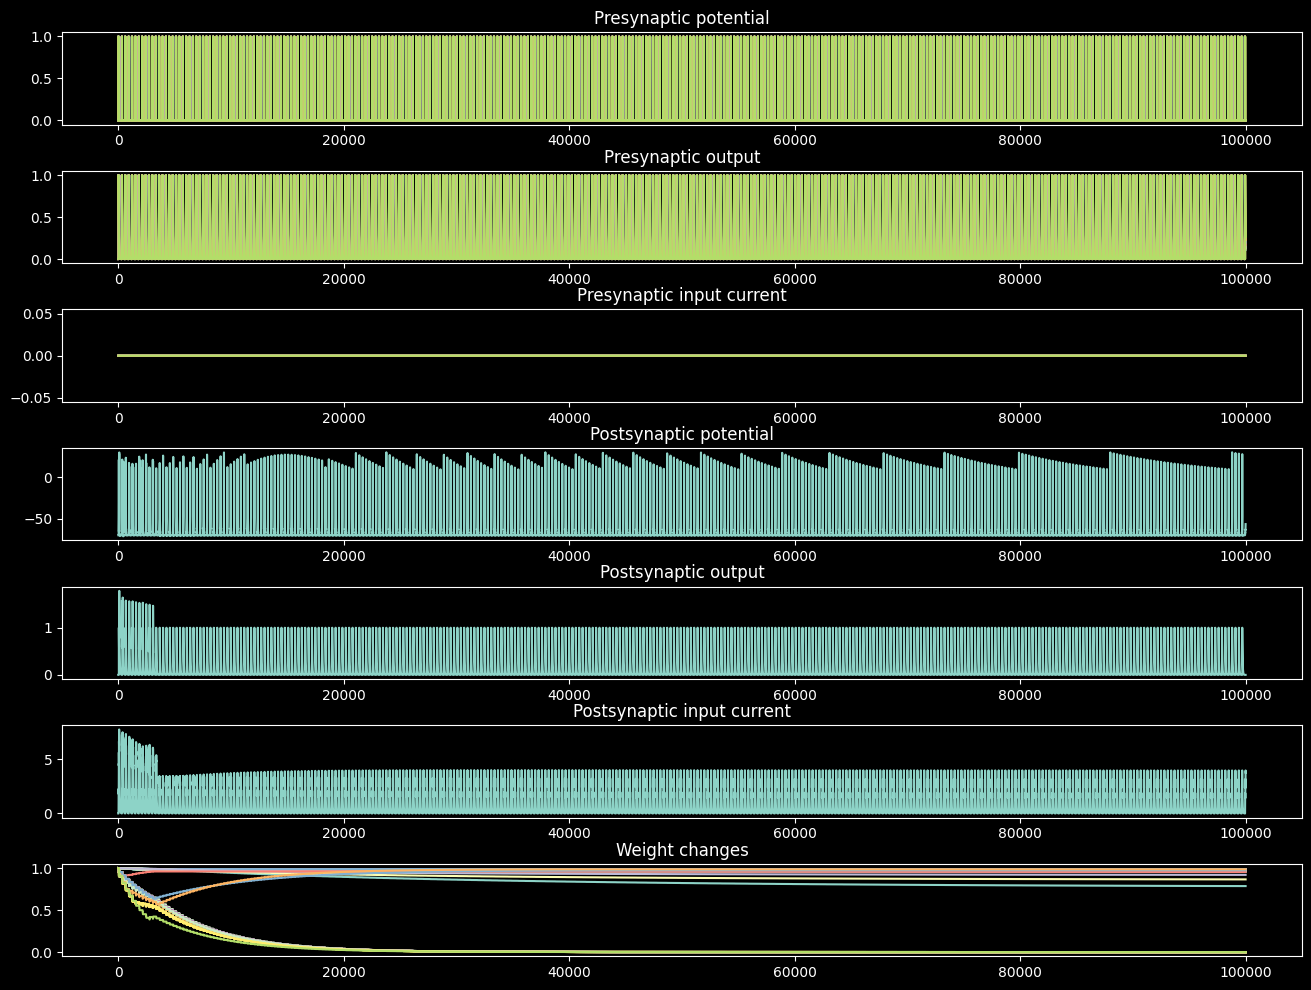

In [12]:
print(data[0])
draw_stats_gatherer(*data, time_range=np.arange(int(train_time / res)) * res)

In [13]:
#weights_0 = gatherer.weights
#draw_convergence(weights_0, total=True)

In [14]:
gatherer = Gatherer(model)
model, gatherer = test_protocol(model, gatherer, patterns, num_rand_patterns, pattern_tries=pattern_tries, test_run_time=test_time, aw=aw, scale=.8)

In [15]:
timings = np.arange(train_time,train_time+test_time*pattern_tries, res)
timings.shape
#print(len(gatherer))
train_time+test_time*pattern_tries

105000

In [16]:
b, a, *_ = gatherer.get_stats(pre_ids=list(np.arange(0,num_input)), post_ids=model.get_output_ids(), timings=timings)
t0 = timings[0]
t1 = timings[-1]+1
#a[:, t0:t1].shape
t0
timings[:-30]

array([100000.        , 100000.1       , 100000.2       , ...,
       104996.70000029, 104996.80000029, 104996.90000029])

In [17]:
timings[:10]
#timings.shape

array([100000. , 100000.1, 100000.2, 100000.3, 100000.4, 100000.5,
       100000.6, 100000.7, 100000.8, 100000.9])

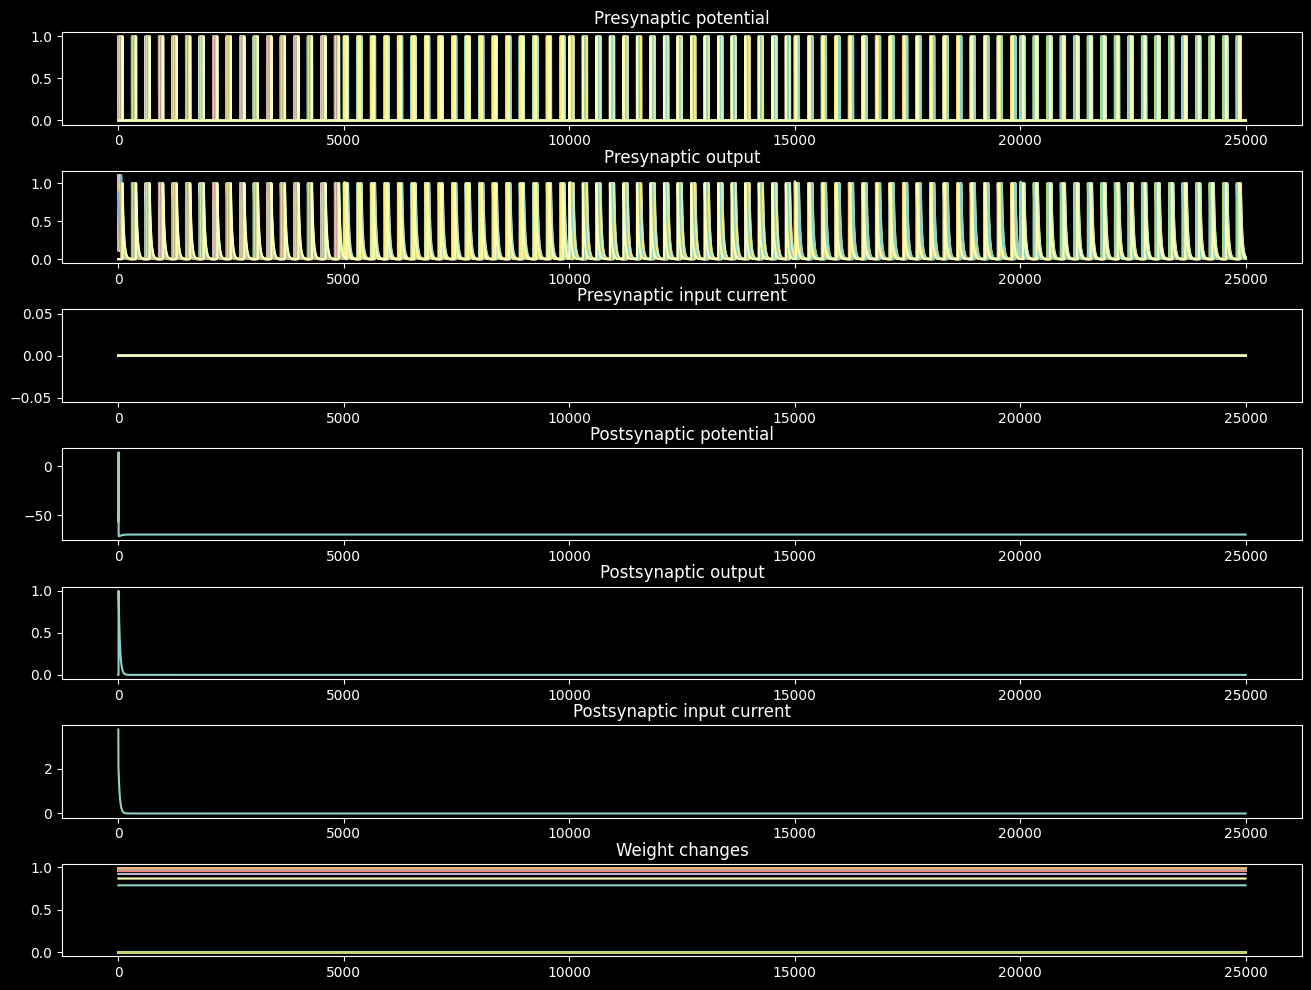

In [18]:
draw_stats_gatherer(*gatherer.get_stats(pre_ids=list(np.arange(0,num_input)), post_ids=model.get_output_ids(), timings=None),
                    time_range=25000, resolution=.1)

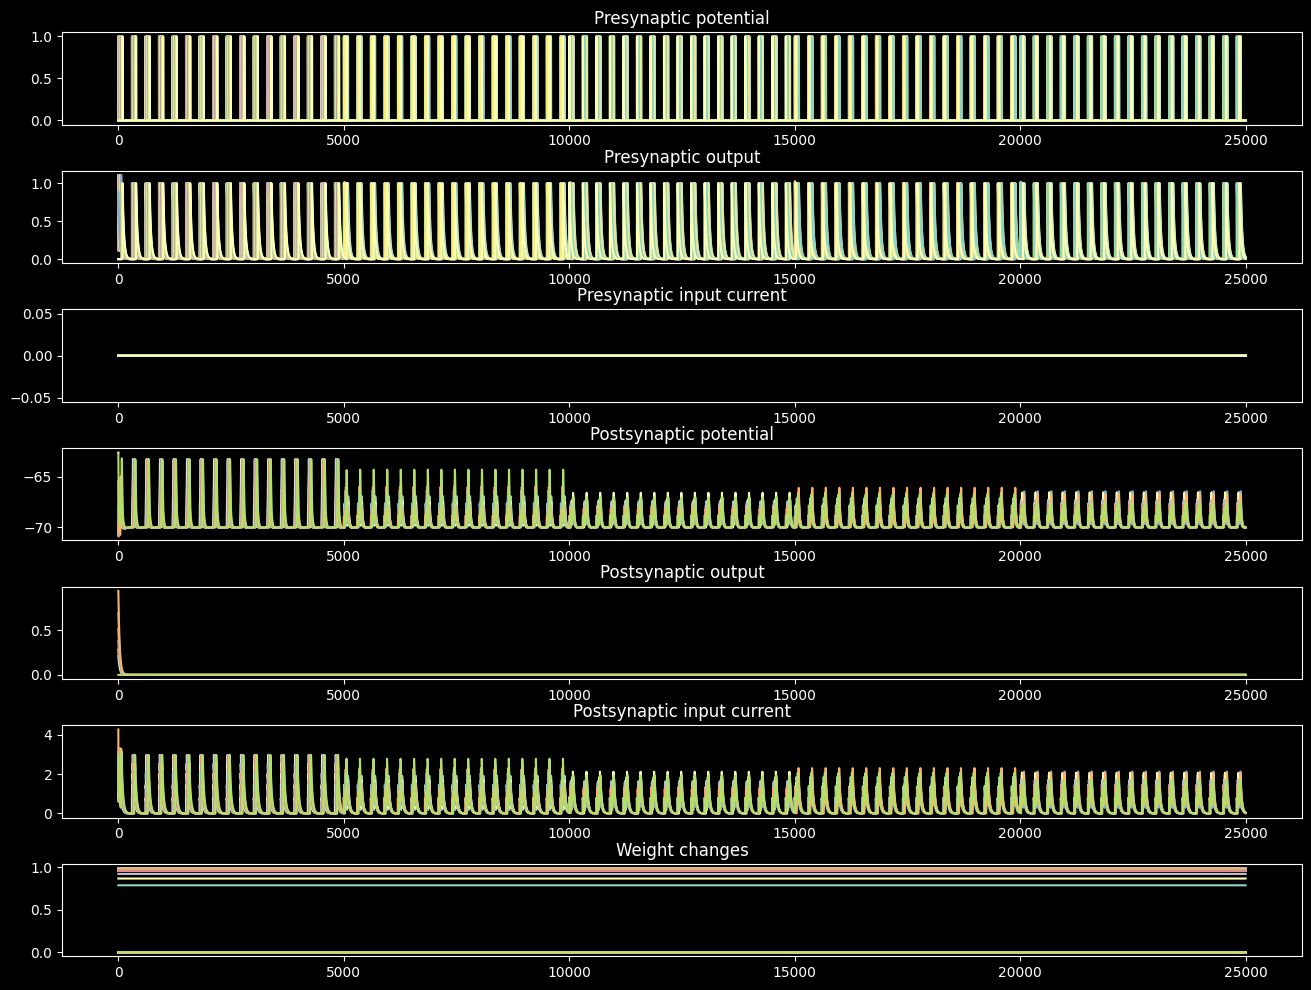

In [19]:
draw_stats_gatherer(*gatherer.get_stats(pre_ids=list(np.arange(0,num_input)), post_ids=model.get_presyn_neurons_ids(model.get_output_ids()[0]), timings=timings),
                    time_range=25000, resolution=.1)

In [20]:
#reverse_order(model, ids=list(range(num_input)))
gatherer = Gatherer(model)
model, gatherer = test_run(model, gatherer, time=5000)

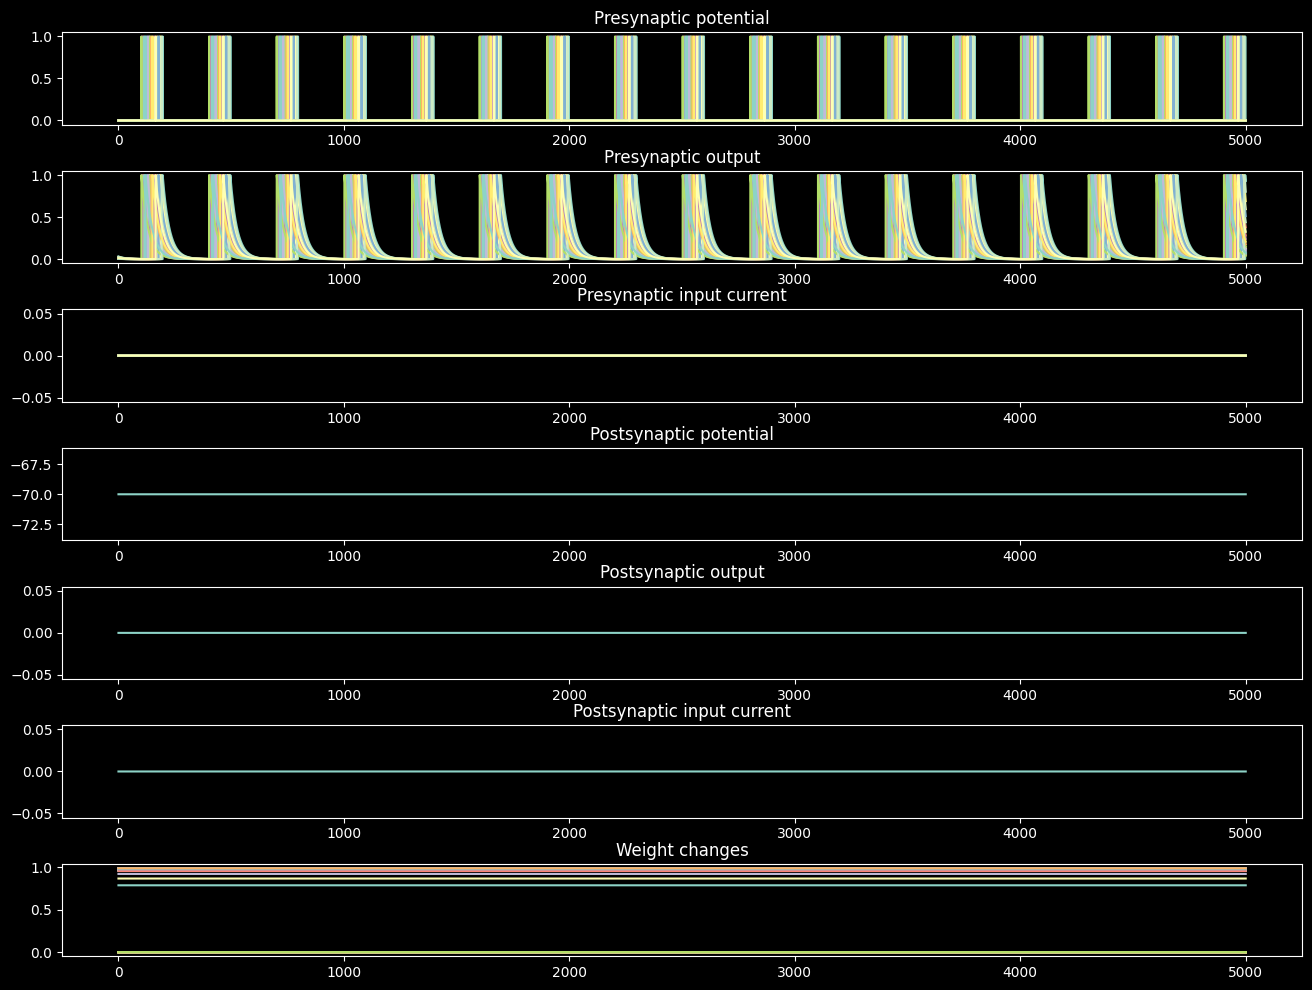

In [21]:
draw_stats_gatherer(*gatherer.get_stats(pre_ids=list(np.arange(0,num_input)), post_ids=model.get_output_ids(), timings=timings),
                    time_range=5000, resolution=.1)

In [22]:
def extract_weights_conv(model, num_input, num_hidden, output_ids):
    in_hid = []
    hid_out = []
    for i in range(num_input, num_input+num_hidden):
        syns = model.get_incoming_synapses(i)
        ws = []
        for s in syns:
            ws.append(s.get_weight())
        in_hid.append(ws)
    for j in range(len(output_ids)):
        syns = model.get_incoming_synapses(output_ids[j])
        ws = []
        for s in syns:
            ws.append(s.get_weight())
        hid_out.append(ws)
    return np.array(in_hid), np.array(hid_out)

w1, w2 = extract_weights_conv(model, num_input, num_hidden, model.get_output_ids())

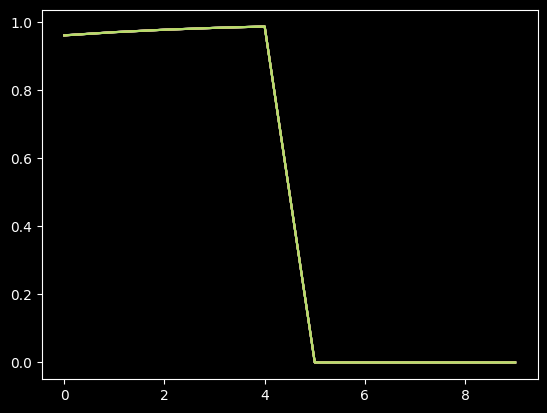

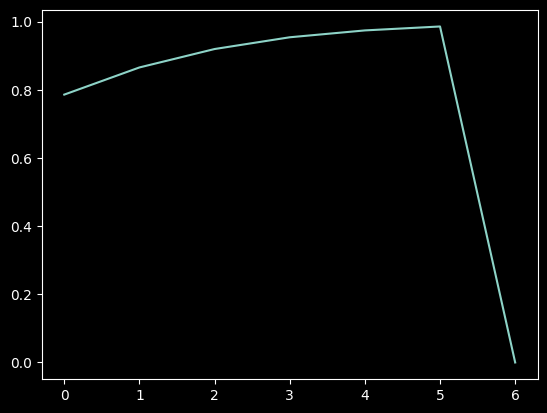

In [23]:
plt.plot(w1.T)
#plt.ylim(-1, 1)
plt.show()
plt.plot(w2.T)
#plt.ylim(0, 1)
plt.show()